<a href="https://colab.research.google.com/github/aryan0931/E-commerce-delivery/blob/main/SCM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-learn tensorflow keras-tuner web3 eth-account py-solc-x eth-tester pandas numpy matplotlib seaborn ipython py-evm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.5/587.5 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.6/798.6 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.3/340.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.8/175.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 114.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from web3 import Web3
from eth_account import Account
from solcx import compile_source, install_solc
from datetime import datetime
import time
from eth_tester import EthereumTester, PyEVMBackend
from web3.providers.eth_tester import EthereumTesterProvider

# Install Solidity compiler
install_solc('0.8.0')

# Solidity smart contract with Proof of Green Compliance
CONTRACT_SOURCE = """
// SPDX-License-Identifier: MIT
pragma solidity ^0.8.0;

contract SupplyChain {
    struct Order {
        string orderId;
        string product;
        uint256 quantity;
        string status;
        uint256 timestamp;
        uint256 emissions; // in kg CO2 * 100 for precision
        address sender;
    }

    mapping(string => Order) public orders;
    uint256 public orderCount;
    uint256 public totalEmissions; // in kg CO2 * 100
    uint256 public emissionThreshold = 1000; // 10 kg CO2 * 100

    event OrderCreated(string orderId, string product, uint256 quantity, uint256 emissions);
    event ShipmentUpdated(string orderId, string status, uint256 emissions);
    event ReorderTriggered(string orderId, string product, uint256 quantity);

    function createOrder(string memory orderId, string memory product, uint256 quantity, uint256 emissions) public {
        require(emissions <= emissionThreshold, "Emissions exceed Proof of Green Compliance threshold");
        require(bytes(orders[orderId].orderId).length == 0, "Order ID already exists");

        orders[orderId] = Order(orderId, product, quantity, "Created", block.timestamp, emissions, msg.sender);
        orderCount++;
        totalEmissions += emissions;
        emit OrderCreated(orderId, product, quantity, emissions);
    }

    function updateShipment(string memory orderId, string memory status, uint256 emissions) public {
        require(bytes(orders[orderId].orderId).length != 0, "Order does not exist");
        require(emissions <= emissionThreshold, "Emissions exceed Proof of Green Compliance threshold");

        orders[orderId].status = status;
        orders[orderId].emissions += emissions;
        totalEmissions += emissions;
        emit ShipmentUpdated(orderId, status, emissions);
    }

    function automateReorder(string memory orderId, string memory product, uint256 currentQuantity, uint256 threshold, string memory newOrderId, uint256 emissions) public {
        require(currentQuantity < threshold, "Current quantity above threshold");
        createOrder(newOrderId, product, threshold - currentQuantity, emissions);
        emit ReorderTriggered(newOrderId, product, threshold - currentQuantity);
    }

    function getOrder(string memory orderId) public view returns (string memory, string memory, uint256, string memory, uint256, uint256, address) {
        Order memory order = orders[orderId];
        return (order.orderId, order.product, order.quantity, order.status, order.timestamp, order.emissions, order.sender);
    }

    function getTotalEmissions() public view returns (uint256) {
        return totalEmissions;
    }
}
"""

# Load and preprocess DataCo dataset
def load_data():
    try:
        file_path = '/content/DataCoSupplyChainDataset.csv'
        df = pd.read_csv(file_path, encoding='latin-1')
        print(f"Successfully loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns")

        df['order date (DateOrders)'] = pd.to_datetime(df['order date (DateOrders)'], errors='coerce')
        if df['order date (DateOrders)'].isna().sum() > 0:
            print(f"Warning: {df['order date (DateOrders)'].isna().sum()} invalid dates set to NaT")

        numerical_cols = ['Order Item Quantity', 'Sales', 'Days for shipping (real)']
        for col in numerical_cols:
            df[col] = df[col].fillna(df[col].mean())
        df.fillna(0, inplace=True)
        print(f"Missing values handled: {numerical_cols} imputed with mean, others with 0")

        # Ensure Product Name is uniformly string
        df['Product Name'] = df['Product Name'].astype(str)
        # Validate Product Name entries
        invalid_entries = df['Product Name'].isna() | (df['Product Name'] == '')
        if invalid_entries.any():
            print(f"Warning: {invalid_entries.sum()} invalid Product Name entries replaced with 'Unknown'")
            df.loc[invalid_entries, 'Product Name'] = 'Unknown'

        le = LabelEncoder()
        df['product'] = le.fit_transform(df['Product Name'])
        print(f"Encoded {len(le.classes_)} unique products")

        required_cols = ['order date (DateOrders)', 'Order Item Quantity', 'Product Name', 'product', 'Sales', 'Days for shipping (real)', 'Shipping Mode']
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")

        # Filter for high-demand products
        df = df[df['Order Item Quantity'] >= 5]
        print(f"Filtered dataset to {df.shape[0]} rows with Order Item Quantity >= 5")

        return df, le
    except FileNotFoundError:
        print(f"Error: {file_path} not found. Please upload DataCoSupplyChainDataset.csv to /content/.")
        print("Download from: https://data.mendeley.com/datasets/8gx2fvg2k6/5")
        print("Use: from google.colab import files; uploaded = files.upload()")
        return None, None
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None, None

# Prepare data for LSTM
def prepare_lstm_data(df, product_id, scaler):
    product_data = df[df['product'] == product_id][['order date (DateOrders)', 'Order Item Quantity']].set_index('order date (DateOrders)')
    product_data = product_data.resample('D').sum().fillna(0)
    data = product_data['Order Item Quantity'].values
    data = scaler.fit_transform(data.reshape(-1, 1)).flatten()
    X, y = [], []
    for i in range(len(data) - 30):
        X.append(data[i:i+30])
        y.append(data[i+30])
    return np.array(X), np.array(y), scaler

# Train LSTM model
def train_lstm(df):
    product_id = df['product'].iloc[0]
    scaler = MinMaxScaler()
    X, y, scaler = prepare_lstm_data(df, product_id, scaler)
    if len(X) == 0:
        print("Error: Insufficient data for LSTM training")
        return None, None, None
    X = X.reshape((X.shape[0], X.shape[1], 1))
    inputs = Input(shape=(30, 1))
    lstm = LSTM(50, activation='relu')(inputs)
    outputs = Dense(1)(lstm)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=50, batch_size=32, verbose=0)
    y_pred = model.predict(X, verbose=0)
    mae = mean_absolute_error(scaler.inverse_transform(y.reshape(-1, 1)), scaler.inverse_transform(y_pred))
    rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y.reshape(-1, 1)), scaler.inverse_transform(y_pred)))
    print(f"LSTM MAE: {mae:.2f} units, RMSE: {rmse:.2f} units")
    return model, product_id, scaler

# Train Random Forest
def train_rf(df):
    X = df[['Order Item Quantity', 'Sales', 'Days for shipping (real)']]
    y = df['Order Item Quantity'] * 1.5
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    y_pred = model.predict(X)
    return model, X.columns

# Optimize emissions
def optimize_emissions(df, product_id):
    product_data = df[df['product'] == product_id][['Shipping Mode', 'Order Item Quantity']]
    emissions_rates = {'Standard Shipping': 0.2, 'Second Class': 0.25, 'First Class': 0.3, 'Same Day': 0.35}
    total_emissions = product_data.groupby('Shipping Mode')['Order Item Quantity'].sum().to_dict()
    for mode in total_emissions:
        total_emissions[mode] *= emissions_rates.get(mode, 0.2)
    recommended_mode = min(emissions_rates, key=lambda x: emissions_rates[x])
    return recommended_mode, total_emissions

# Setup mock blockchain with eth-tester
def setup_mock_blockchain():
    try:
        print("Setting up mock blockchain with eth-tester...")
        tester = EthereumTester(backend=PyEVMBackend())
        w3 = Web3(EthereumTesterProvider(tester))
        account = tester.get_accounts()[0]

        # Compile Solidity contract
        compiled_sol = compile_source(CONTRACT_SOURCE, output_values=['abi', 'bin'])
        contract_interface = compiled_sol['<stdin>:SupplyChain']
        abi = contract_interface['abi']
        bytecode = contract_interface['bin']

        # Deploy contract
        contract = w3.eth.contract(abi=abi, bytecode=bytecode)
        tx_hash = contract.constructor().transact({'from': account})
        tx_receipt = w3.eth.get_transaction_receipt(tx_hash)
        contract_address = tx_receipt.contractAddress
        contract_instance = w3.eth.contract(address=contract_address, abi=abi)

        return w3, contract_instance, account
    except Exception as e:
        print(f"Error setting up mock blockchain: {str(e)}")
        return None, None, None

# Main execution
def main():
    print("=== Decentralized Autonomous Supply Chain Organization (DASCO) ===")
    print("Demonstrating ML and Ethereum Blockchain with Proof of Green Compliance\n")

    # Setup blockchain
    w3, contract, account = setup_mock_blockchain()
    if w3 is None:
        print("Failed to setup blockchain. Exiting...")
        return
    print(f"Mock Blockchain: Contract deployed at {contract.address}")

    # Load dataset
    df, le = load_data()
    if df is None:
        return

    # Train ML models
    lstm_model, product_id, scaler = train_lstm(df)
    rf_model, rf_columns = train_rf(df)

    if lstm_model is None or product_id is None:
        return

    # ML predictions
    X, _, _ = prepare_lstm_data(df, product_id, scaler)
    if len(X) == 0:
        print("Error: No data available for prediction")
        return
    X = X[-1].reshape((1, 30, 1))
    demand_scaled = lstm_model.predict(X, verbose=0)[0][0]
    demand = scaler.inverse_transform([[demand_scaled]])[0][0]

    sample = pd.DataFrame([df[['Order Item Quantity', 'Sales', 'Days for shipping (real)']].iloc[0].values], columns=rf_columns)
    optimal_stock = rf_model.predict(sample)[0]

    recommended_mode, emissions_data = optimize_emissions(df, product_id)

    # Blockchain transactions
    product_name = le.inverse_transform([product_id])[0]
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    current_quantity = 2  # Adjusted to trigger reorder
    threshold = int(optimal_stock)

    try:
        # Create order
        order_id = 'TX001'
        quantity = current_quantity
        emissions = int(quantity * 0.2 * 100)  # kg CO2 * 100
        tx_hash = contract.functions.createOrder(order_id, product_name, quantity, emissions).transact({'from': account, 'gas': 1000000})
        receipt = w3.eth.wait_for_transaction_receipt(tx_hash)
        print(f"Blockchain: Created order {order_id} for {quantity} units of {product_name} (Emissions: {emissions/100:.2f} kg CO2, Tx Hash: {tx_hash.hex()})")

        # Update shipment
        emissions_update = int(quantity * 0.1 * 100)
        tx_hash = contract.functions.updateShipment(order_id, "In Transit", emissions_update).transact({'from': account, 'gas': 1000000})
        receipt = w3.eth.wait_for_transaction_receipt(tx_hash)
        print(f"Blockchain: Updated order {order_id} to 'In Transit' (Emissions: {emissions_update/100:.2f} kg CO2, Tx Hash: {tx_hash.hex()})")

        # Automate reorder
        new_order_id = f"REORDER_TX001_{int(time.time())}"
        emissions_reorder = int((threshold - current_quantity) * 0.1 * 100)
        tx_hash = contract.functions.automateReorder(order_id, product_name, current_quantity, threshold, new_order_id, emissions_reorder).transact({'from': account, 'gas': 1000000})
        receipt = w3.eth.wait_for_transaction_receipt(tx_hash)
        print(f"Blockchain: Triggered reorder {new_order_id} for {threshold - current_quantity} units (Emissions: {emissions_reorder/100:.2f} kg CO2, Tx Hash: {tx_hash.hex()})")

        # Retrieve transactions
        order_count = contract.functions.orderCount().call()
        total_emissions = contract.functions.getTotalEmissions().call() / 100
        orders = []
        for order_id_to_fetch in ['TX001', new_order_id]:
            try:
                order_data = contract.functions.getOrder(order_id_to_fetch).call()
                orders.append({
                    'orderId': order_data[0],
                    'product': order_data[1],
                    'quantity': order_data[2],
                    'status': order_data[3],
                    'timestamp': datetime.fromtimestamp(order_data[4]).strftime('%Y-%m-%d %H:%M:%S'),
                    'emissions': order_data[5] / 100,
                    'sender': order_data[6]
                })
            except:
                continue

    except Exception as e:
        print(f"Blockchain Error: {str(e)}")
        return

    # Display results
    print("\n1. ML Demand Prediction:")
    print(f"   Product: {product_name}")
    print(f"   Predicted Demand: {round(float(demand), 2)} units")
    print(f"   Date: {timestamp.split()[0]}\n")

    print("2. Inventory Optimization:")
    print(f"   Product: {product_name}")
    print(f"   Optimal Stock: {round(float(optimal_stock), 2)} units")
    print(f"   Current Stock: {current_quantity} units")
    print(f"   Reorder Threshold: {threshold} units\n")

    print("3. Sustainability Analysis:")
    print(f"   Recommended Shipping Mode: {recommended_mode} (lowest emissions)")
    print(f"   Current Emissions by Mode: {emissions_data}")
    print(f"   Total Emissions Recorded on Blockchain: {total_emissions:.2f} kg CO2\n")

    print("4. Blockchain Transactions (Proof of Green Compliance):")
    for order in orders:
        print(f"   ID: {order['orderId']}, Product: {order['product']}, Quantity: {order['quantity']}, "
              f"Status: {order['status']}, Emissions: {order['emissions']:.2f} kg CO2, Timestamp: {order['timestamp']}, Sender: {order['sender']}")

    print("\n=== Summary ===")
    print("This prototype demonstrates DASCO's integration of ML and Ethereum blockchain with Proof of Green Compliance, ensuring transparent, automated, and sustainable supply chain management.")

if __name__ == '__main__':
    main()

=== Decentralized Autonomous Supply Chain Organization (DASCO) ===
Demonstrating ML and Ethereum Blockchain with Proof of Green Compliance

Setting up mock blockchain with eth-tester...
Mock Blockchain: Contract deployed at 0xF2E246BB76DF876Cef8b38ae84130F4F55De395b
Successfully loaded dataset with 175670 rows and 53 columns
Missing values handled: ['Order Item Quantity', 'Sales', 'Days for shipping (real)'] imputed with mean, others with 0
Encoded 119 unique products
Filtered dataset to 19553 rows with Order Item Quantity >= 5
LSTM MAE: 8.34 units, RMSE: 10.23 units
Blockchain: Created order TX001 for 2 units of Nike Men's Dri-FIT Victory Golf Polo (Emissions: 0.40 kg CO2, Tx Hash: 8c94a2c4a8f975e2c2124a3de7657ae31b73963b9d11b2f09a6a6ca33a0027c4)
Blockchain: Updated order TX001 to 'In Transit' (Emissions: 0.20 kg CO2, Tx Hash: 327d1e6d4a38a4f952f2414974f149526308fd40407483d38e6878b4a154661b)
Blockchain: Triggered reorder REORDER_TX001_1763889806 for 5 units (Emissions: 0.50 kg CO2, Tx

=== Decentralized Autonomous Supply Chain Organization (DASCO) ===

Attempting to install solc 0.8.0 (if not already installed)...
Setting up eth-tester backend...
Deployed contract at address: 0xF2E246BB76DF876Cef8b38ae84130F4F55De395b
Mock Blockchain ready. Deployer account: 0x7E5F4552091A69125d5DfCb7b8C2659029395Bdf



/tmp/ipython-input-2239006780.py:132: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mean_val, inplace=True)


Loaded dataset with shape: (180519, 54) and 118 unique products

--- Feature 1: Anomaly Detection ---
✓ Anomaly Detector trained
✓ Detected 17461 anomalies (9.67%)
No product_id provided. Using most frequent product: 71
Training LSTM for product 71 — epochs=20, lookback=30
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.1616 - val_loss: 0.0260
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0317 - val_loss: 0.0276
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0296 - val_loss: 0.0259
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0291 - val_loss: 0.0259
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0295 - val_loss: 0.0274
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0287 - val_loss: 0.0274
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0294 - val_loss: 0.0263
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0312 - val_loss: 0.0269
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - l

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


✓ Found 10 product correlations
Blockchain: Created order TX001
Blockchain: Updated shipment for TX001

=== Results ===

1) ML Demand Prediction:
   Product: Perfect Fitness Perfect Rip Deck
   Predicted Demand: 67.79 units

2) Inventory Optimization:
   Optimal Stock: 1.00 units

3) Sustainability Analysis:
   Recommended Mode: Standard Shipping
   Total Emissions (Blockchain): 0.60 kg CO2

4) Blockchain Transactions:
   ID: TX001, Status: In Transit, Emissions: 0.60

--- Feature 6: Dashboard ---

📊 Creating dashboard...
✓ Dashboard saved: dasco_dashboard.png


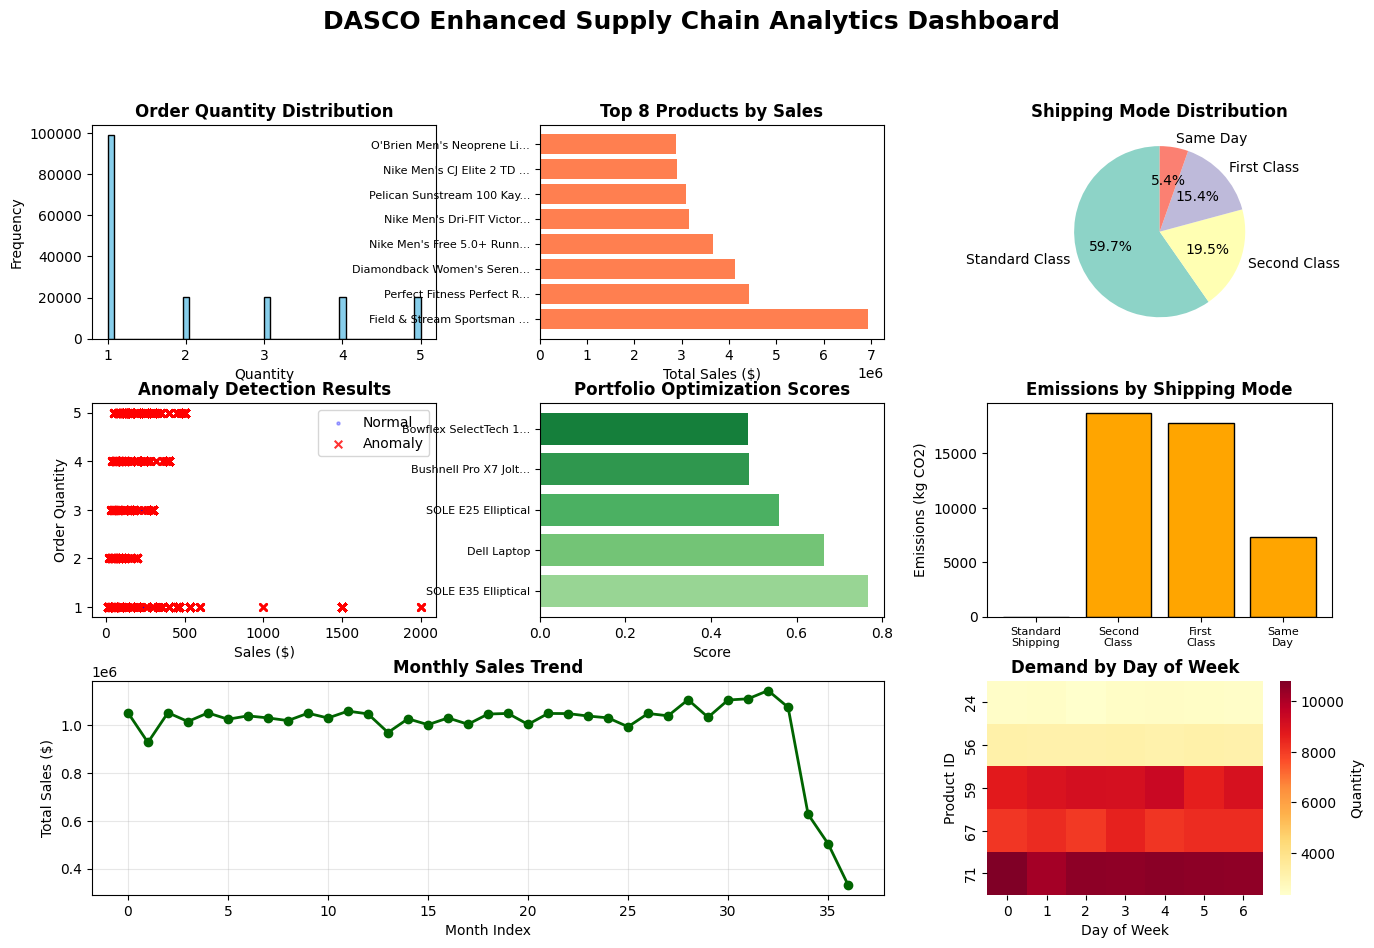


=== Summary ===
Integrated System: Blockchain + ML + Analytics + Dashboard


In [10]:
# DASCO prototype — improved single-file script
# Features:
# - Robust data loading and validation
# - LSTM forecasting with train/validation, scaler handling
# - RandomForest predicting order quantity (train/test + scaler)
# - Correct emissions optimization (min total emissions)
# - Robust eth-tester mock blockchain setup & solidity compile/deploy
# - Clear prints and error handling

import os
import time
from datetime import datetime

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# blockchain imports
from web3 import Web3
from solcx import compile_source, install_solc
from eth_tester import EthereumTester, PyEVMBackend
from web3.providers.eth_tester import EthereumTesterProvider

from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns


# Solidity contract (unchanged structure except comments)
CONTRACT_SOURCE = """
// SPDX-License-Identifier: MIT
pragma solidity ^0.8.0;

contract SupplyChain {
    struct Order {
        string orderId;
        string product;
        uint256 quantity;
        string status;
        uint256 timestamp;
        uint256 emissions; // in kg CO2 * 100 for precision
        address sender;
    }

    mapping(string => Order) public orders;
    uint256 public orderCount;
    uint256 public totalEmissions; // in kg CO2 * 100
    uint256 public emissionThreshold = 1000; // 10 kg CO2 * 100

    event OrderCreated(string orderId, string product, uint256 quantity, uint256 emissions);
    event ShipmentUpdated(string orderId, string status, uint256 emissions);
    event ReorderTriggered(string orderId, string product, uint256 quantity);

    function createOrder(string memory orderId, string memory product, uint256 quantity, uint256 emissions) public {
        require(emissions <= emissionThreshold, "Emissions exceed Proof of Green Compliance threshold");
        require(bytes(orders[orderId].orderId).length == 0, "Order ID already exists");

        orders[orderId] = Order(orderId, product, quantity, "Created", block.timestamp, emissions, msg.sender);
        orderCount++;
        totalEmissions += emissions;
        emit OrderCreated(orderId, product, quantity, emissions);
    }

    function updateShipment(string memory orderId, string memory status, uint256 emissions) public {
        require(bytes(orders[orderId].orderId).length != 0, "Order does not exist");
        require(emissions <= emissionThreshold, "Emissions exceed Proof of Green Compliance threshold");

        orders[orderId].status = status;
        orders[orderId].emissions += emissions;
        totalEmissions += emissions;
        emit ShipmentUpdated(orderId, status, emissions);
    }

    function automateReorder(string memory orderId, string memory product, uint256 currentQuantity, uint256 threshold, string memory newOrderId, uint256 emissions) public {
        require(currentQuantity < threshold, "Current quantity above threshold");
        createOrder(newOrderId, product, threshold - currentQuantity, emissions);
        emit ReorderTriggered(newOrderId, product, threshold - currentQuantity);
    }

    function getOrder(string memory orderId) public view returns (string memory, string memory, uint256, string memory, uint256, uint256, address) {
        Order memory order = orders[orderId];
        return (order.orderId, order.product, order.quantity, order.status, order.timestamp, order.emissions, order.sender);
    }

    function getTotalEmissions() public view returns (uint256) {
        return totalEmissions;
    }
}
"""

# -------------------------
# Data loading & preprocessing
# -------------------------
def load_data(file_path='/content/DataCoSupplyChainDataset.csv', min_qty_filter=None):
    """
    Load the DataCo dataset with safer checks.
    min_qty_filter: if provided, filter Order Item Quantity >= min_qty_filter (optional).
    Returns: df (pandas.DataFrame), label_encoder (LabelEncoder for product names)
    """
    if not os.path.exists(file_path):
        print(f"Error: dataset not found at {file_path}. Please upload the file or change file_path.")
        return None, None

    try:
        df = pd.read_csv(file_path, encoding='latin-1')
        # normalize column names (strip whitespace)
        df.columns = [c.strip() for c in df.columns]

        # required columns (adapt if your CSV has slightly different names)
        required_cols = ['order date (DateOrders)', 'Order Item Quantity', 'Product Name', 'Sales', 'Days for shipping (real)', 'Shipping Mode']
        missing_cols = [c for c in required_cols if c not in df.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")

        # parse dates
        df['order date (DateOrders)'] = pd.to_datetime(df['order date (DateOrders)'], errors='coerce')
        if df['order date (DateOrders)'].isna().sum() > 0:
            print(f"Warning: {df['order date (DateOrders)'].isna().sum()} invalid dates set to NaT")

        # numeric conversions & imputation for numeric columns only
        num_cols = ['Order Item Quantity', 'Sales', 'Days for shipping (real)']
        for col in num_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            mean_val = df[col].mean()
            df[col].fillna(mean_val, inplace=True)

        # Product Name handling
        df['Product Name'] = df['Product Name'].astype(str).fillna('Unknown')
        invalid_entries = df['Product Name'].isna() | (df['Product Name'] == '')
        if invalid_entries.any():
            df.loc[invalid_entries, 'Product Name'] = 'Unknown'

        # encode product
        le = LabelEncoder()
        df['product'] = le.fit_transform(df['Product Name'])

        # optional filter by minimum order item quantity
        if min_qty_filter is not None:
            before = len(df)
            df = df[df['Order Item Quantity'] >= min_qty_filter].copy()
            after = len(df)
            print(f"Applied min_qty_filter={min_qty_filter}: rows {before} -> {after}")

        print(f"Loaded dataset with shape: {df.shape} and {len(le.classes_)} unique products")
        return df, le

    except Exception as e:
        print("Error loading data:", e)
        return None, None

# -------------------------
# LSTM time-series preparation and training
# -------------------------
def prepare_lstm_data(df, product_id, scaler=None, lookback=30):
    """
    Prepare daily-resampled time series for a particular product.
    Returns X (num_samples, lookback), y (num_samples,), scaler (fitted)
    """
    prod_df = df[df['product'] == product_id][['order date (DateOrders)', 'Order Item Quantity']].copy()
    if prod_df.empty:
        return np.array([]), np.array([]), scaler

    prod_df = prod_df.set_index('order date (DateOrders)').sort_index()
    # resample to daily frequency and sum quantities per day
    prod_daily = prod_df.resample('D').sum().fillna(0)
    data = prod_daily['Order Item Quantity'].values.reshape(-1, 1)

    # Always fit the scaler on the current data
    if scaler is None:
        scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    X, y = [], []
    for i in range(len(data_scaled) - lookback):
        X.append(data_scaled[i:i + lookback, 0])
        y.append(data_scaled[i + lookback, 0])

    return np.array(X), np.array(y), scaler

def train_lstm(df, product_id=None, lookback=30, epochs=30):
    """
    Train an LSTM on the product time series.
    If product_id is None, chooses product with most records.
    Returns model, product_id, scaler
    """
    if product_id is None:
        product_id = df['product'].value_counts().idxmax()
        print(f"No product_id provided. Using most frequent product: {product_id}")

    scaler = MinMaxScaler()
    X, y, scaler = prepare_lstm_data(df, product_id, scaler=scaler, lookback=lookback)
    if len(X) == 0:
        print("Insufficient data for LSTM training")
        return None, None, None

    # train/validation split (time-order preserved)
    split = int(len(X) * 0.8)
    X_train, X_val = X[:split], X[split:]
    y_train, y_val = y[:split], y[split:]

    # reshape for LSTM
    X_train = X_train.reshape((X_train.shape[0], lookback, 1))
    X_val = X_val.reshape((X_val.shape[0], lookback, 1))

    inputs = Input(shape=(lookback, 1))
    lstm = LSTM(50)(inputs)  # default tanh internal activations
    outputs = Dense(1)(lstm)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')

    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    print(f"Training LSTM for product {product_id} — epochs={epochs}, lookback={lookback}")
    model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_val, y_val), callbacks=[es], verbose=1)

    # validation metrics
    if len(X_val) > 0:
        y_val_pred = model.predict(X_val, verbose=0)
        y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
        y_val_pred_inv = scaler.inverse_transform(y_val_pred).flatten()
        val_mae = mean_absolute_error(y_val_inv, y_val_pred_inv)
        val_rmse = np.sqrt(mean_squared_error(y_val_inv, y_val_pred_inv))
        print(f"LSTM Validation MAE: {val_mae:.2f}, RMSE: {val_rmse:.2f}")
    else:
        print("No validation split available to report metrics.")

    return model, product_id, scaler

# -------------------------
# Random Forest training (predicting Order Item Quantity)
# -------------------------
def train_rf(df):
    """
    Train RF to predict Order Item Quantity using Sales and Days for shipping (real).
    Returns model, feature_columns (list), scaler
    """
    X = df[['Sales', 'Days for shipping (real)']].copy()
    y = df['Order Item Quantity'].copy().astype(float)

    # simple train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_sc, y_train)

    y_pred = model.predict(X_test_sc)
    print(f"RF Test MAE: {mean_absolute_error(y_test, y_pred):.2f}, RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}, R2: {r2_score(y_test, y_pred):.3f}")

    return model, X.columns.tolist(), scaler

# -------------------------
# Emissions optimization
# -------------------------
def optimize_emissions(df, product_id):
    """
    Compute total emissions per shipping mode for a product and recommend the mode that
    minimizes total emissions (qty * per-unit-rate).
    Returns recommended_mode, dict(total_emissions_by_mode)
    """
    product_data = df[df['product'] == product_id][['Shipping Mode', 'Order Item Quantity']].copy()
    # default per-unit emissions (kg CO2 per unit)
    emissions_rates = {'Standard Shipping': 0.2, 'Second Class': 0.25, 'First Class': 0.3, 'Same Day': 0.35}

    totals = product_data.groupby('Shipping Mode')['Order Item Quantity'].sum().to_dict()
    total_emissions_by_mode = {mode: totals.get(mode, 0.0) * emissions_rates.get(mode, 0.2) for mode in emissions_rates}

    recommended_mode = min(total_emissions_by_mode, key=lambda m: total_emissions_by_mode[m])
    return recommended_mode, total_emissions_by_mode

# -------------------------
# Mock blockchain setup (eth-tester) with robust deploy/tx handling
# -------------------------
def setup_mock_blockchain():
    """
    Sets up an eth-tester blockchain, compiles the solidity contract, deploys and returns:
    w3 (Web3), contract_instance (Contract), account (deployer address)
    """
    try:
        print("Attempting to install solc 0.8.0 (if not already installed)...")
        try:
            install_solc('0.8.0')
        except Exception as e:
            print("Warning: install_solc failed or network not available. If compile fails, install a local solc 0.8.x manually. Error:", e)

        print("Setting up eth-tester backend...")
        tester = EthereumTester(backend=PyEVMBackend())
        w3 = Web3(EthereumTesterProvider(tester))
        account = tester.get_accounts()[0]
        w3.eth.default_account = account

        # compile
        compiled = compile_source(CONTRACT_SOURCE, output_values=['abi', 'bin'])
        contract_key = next(iter(compiled.keys()))
        contract_interface = compiled[contract_key]
        abi = contract_interface['abi']
        bytecode = contract_interface['bin']

        # deploy (wait for receipt)
        contract_factory = w3.eth.contract(abi=abi, bytecode=bytecode)
        tx_hash = contract_factory.constructor().transact()
        tx_receipt = w3.eth.wait_for_transaction_receipt(tx_hash)
        contract_address = tx_receipt.contractAddress
        contract_instance = w3.eth.contract(address=contract_address, abi=abi)

        print(f"Deployed contract at address: {contract_address}")
        return w3, contract_instance, account

    except Exception as e:
        print("Error setting up mock blockchain:", e)
        return None, None, None

# -------------------------
# Main execution
# -------------------------

class AnomalyDetector:
    """NEW FEATURE 1: Real-time Anomaly Detection using Isolation Forest"""
    def __init__(self, contamination=0.1):
        self.model = IsolationForest(contamination=contamination, random_state=42)
        self.scaler = StandardScaler()

    def train(self, df):
        features = df[['Order Item Quantity', 'Sales', 'Days for shipping (real)']].copy()
        features_scaled = self.scaler.fit_transform(features)
        self.model.fit(features_scaled)
        print("✓ Anomaly Detector trained")

    def detect(self, df):
        features = df[['Order Item Quantity', 'Sales', 'Days for shipping (real)']].copy()
        features_scaled = self.scaler.transform(features)
        predictions = self.model.predict(features_scaled)
        anomaly_scores = self.model.score_samples(features_scaled)

        df['is_anomaly'] = predictions == -1
        df['anomaly_score'] = anomaly_scores

        anomaly_count = df['is_anomaly'].sum()
        print(f"✓ Detected {anomaly_count} anomalies ({anomaly_count/len(df)*100:.2f}%)")
        return df


class PortfolioOptimizer:
    """NEW FEATURE 2: Multi-Product Portfolio Optimization"""
    def __init__(self, df, le):
        self.df = df
        self.le = le

    def optimize_portfolio(self, top_n=5):
        print(f"\n🔍 Analyzing top {top_n} products for portfolio optimization...")

        # Calculate metrics per product
        product_stats = self.df.groupby('product').agg({
            'Order Item Quantity': ['sum', 'mean', 'std'],
            'Sales': 'sum',
            'Days for shipping (real)': 'mean'
        }).reset_index()

        product_stats.columns = ['product', 'total_qty', 'avg_qty', 'std_qty', 'total_sales', 'avg_shipping_days']
        product_stats['revenue_per_unit'] = product_stats['total_sales'] / product_stats['total_qty']
        product_stats['consistency_score'] = 1 / (1 + product_stats['std_qty'])
        product_stats['efficiency_score'] = 1 / (1 + product_stats['avg_shipping_days'])

        # Composite score
        product_stats['portfolio_score'] = (
            0.4 * product_stats['revenue_per_unit'] / product_stats['revenue_per_unit'].max() +
            0.3 * product_stats['consistency_score'] +
            0.3 * product_stats['efficiency_score']
        )

        top_products = product_stats.nlargest(top_n, 'portfolio_score')

        results = []
        for _, row in top_products.iterrows():
            product_name = self.le.inverse_transform([int(row['product'])])[0]
            results.append({
                'product_id': int(row['product']),
                'product_name': product_name,
                'portfolio_score': row['portfolio_score'],
                'total_sales': row['total_sales'],
                'avg_qty': row['avg_qty']
            })

        print(f"✓ Portfolio optimized with {len(results)} products")
        return results


class DemandCorrelationAnalyzer:
    """Feature 3: Cross-Product Demand Correlation Analysis"""
    def __init__(self, df):
        self.df = df

    def analyze_correlations(self, top_n=10):
        print(f"\n🔍 Analyzing correlations for top {top_n} products...")

        top_products = self.df['product'].value_counts().head(top_n).index

        daily_demand = self.df[self.df['product'].isin(top_products)].pivot_table(
            index='order date (DateOrders)',
            columns='product',
            values='Order Item Quantity',
            aggfunc='sum'
        ).fillna(0)

        correlation_matrix = daily_demand.corr()

        correlations = []
        for i in range(len(correlation_matrix)):
            for j in range(i+1, len(correlation_matrix)):
                correlations.append({
                    'product1': correlation_matrix.index[i],
                    'product2': correlation_matrix.columns[j],
                    'correlation': correlation_matrix.iloc[i, j]
                })

        correlations_df = pd.DataFrame(correlations)
        correlations_df = correlations_df.sort_values('correlation', ascending=False)

        print(f"✓ Found {len(correlations_df)} product correlations")
        return correlations_df.head(5), correlation_matrix



class VisualizationDashboard:
    """Feature 6: Advanced Visualization Dashboard"""
    @staticmethod
    def create_dashboard(df, portfolio_results, anomaly_df):
        print("\n📊 Creating dashboard...")

        fig = plt.figure(figsize=(16, 10))
        gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

        # 1. Order Quantity Distribution
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.hist(df['Order Item Quantity'], bins=50, color='skyblue', edgecolor='black')
        ax1.set_title('Order Quantity Distribution', fontweight='bold')
        ax1.set_xlabel('Quantity')
        ax1.set_ylabel('Frequency')

        # 2. Top Products by Sales
        ax2 = fig.add_subplot(gs[0, 1])
        top_sales = df.groupby('Product Name')['Sales'].sum().nlargest(8)
        ax2.barh(range(len(top_sales)), top_sales.values, color='coral')
        ax2.set_yticks(range(len(top_sales)))
        ax2.set_yticklabels([name[:25] + '...' if len(name) > 25 else name for name in top_sales.index], fontsize=8)
        ax2.set_title('Top 8 Products by Sales', fontweight='bold')
        ax2.set_xlabel('Total Sales ($)')

        # 3. Shipping Mode Pie Chart
        ax3 = fig.add_subplot(gs[0, 2])
        shipping_dist = df['Shipping Mode'].value_counts()
        colors = plt.cm.Set3(range(len(shipping_dist)))
        ax3.pie(shipping_dist.values, labels=shipping_dist.index, autopct='%1.1f%%',
               startangle=90, colors=colors)
        ax3.set_title('Shipping Mode Distribution', fontweight='bold')

        # 4. Anomaly Detection Scatter
        ax4 = fig.add_subplot(gs[1, 0])
        if 'is_anomaly' in anomaly_df.columns:
            normal = anomaly_df[anomaly_df['is_anomaly'] == False]
            anomaly = anomaly_df[anomaly_df['is_anomaly'] == True]
            ax4.scatter(normal['Sales'], normal['Order Item Quantity'],
                       alpha=0.3, s=5, label='Normal', color='blue')
            ax4.scatter(anomaly['Sales'], anomaly['Order Item Quantity'],
                       alpha=0.8, s=30, label='Anomaly', color='red', marker='x')
            ax4.set_title('Anomaly Detection Results', fontweight='bold')
            ax4.set_xlabel('Sales ($)')
            ax4.set_ylabel('Order Quantity')
            ax4.legend()

        # 5. Portfolio Scores
        ax5 = fig.add_subplot(gs[1, 1])
        if portfolio_results:
            portfolio_df = pd.DataFrame(portfolio_results)
            colors_portfolio = plt.cm.Greens(np.linspace(0.4, 0.8, len(portfolio_df)))
            ax5.barh(range(len(portfolio_df)), portfolio_df['portfolio_score'], color=colors_portfolio)
            ax5.set_yticks(range(len(portfolio_df)))
            ax5.set_yticklabels([name[:20] + '...' if len(name) > 20 else name
                                for name in portfolio_df['product_name']], fontsize=8)
            ax5.set_title('Portfolio Optimization Scores', fontweight='bold')
            ax5.set_xlabel('Score')

        # 6. Emissions by Mode
        ax6 = fig.add_subplot(gs[1, 2])
        emissions_rates = {'Standard Shipping': 0.2, 'Second Class': 0.25,
                          'First Class': 0.3, 'Same Day': 0.35}
        emissions_by_mode = {}
        for mode, rate in emissions_rates.items():
            qty = df[df['Shipping Mode'] == mode]['Order Item Quantity'].sum()
            emissions_by_mode[mode] = qty * rate

        ax6.bar(range(len(emissions_by_mode)), list(emissions_by_mode.values()),
               color='orange', edgecolor='black')
        ax6.set_xticks(range(len(emissions_by_mode)))
        ax6.set_xticklabels([m.replace(' ', '\n') for m in emissions_by_mode.keys()],
                            fontsize=8, rotation=0)
        ax6.set_title('Emissions by Shipping Mode', fontweight='bold')
        ax6.set_ylabel('Emissions (kg CO2)')

        # 7. Sales Trend Over Time
        ax7 = fig.add_subplot(gs[2, :2])
        monthly_sales = df.groupby(df['order date (DateOrders)'].dt.to_period('M'))['Sales'].sum()
        ax7.plot(range(len(monthly_sales)), monthly_sales.values,
                marker='o', linewidth=2, color='darkgreen')
        ax7.set_title('Monthly Sales Trend', fontweight='bold')
        ax7.set_xlabel('Month Index')
        ax7.set_ylabel('Total Sales ($)')
        ax7.grid(True, alpha=0.3)

        # 8. Demand Heatmap (simplified)
        ax8 = fig.add_subplot(gs[2, 2])
        top_5_products = df['product'].value_counts().head(5).index
        heatmap_data = df[df['product'].isin(top_5_products)].groupby(
            ['product', df['order date (DateOrders)'].dt.dayofweek]
        )['Order Item Quantity'].sum().unstack(fill_value=0)

        if not heatmap_data.empty:
            sns.heatmap(heatmap_data, cmap='YlOrRd', ax=ax8, cbar_kws={'label': 'Quantity'})
            ax8.set_title('Demand by Day of Week', fontweight='bold')
            ax8.set_xlabel('Day of Week')
            ax8.set_ylabel('Product ID')

        plt.suptitle('DASCO Enhanced Supply Chain Analytics Dashboard',
                    fontsize=18, fontweight='bold', y=0.995)

        plt.savefig('dasco_dashboard.png', dpi=300, bbox_inches='tight')
        print("✓ Dashboard saved: dasco_dashboard.png")
        plt.show()


def main():
    print("=== Decentralized Autonomous Supply Chain Organization (DASCO) ===\n")

    # 1) Setup blockchain
    w3, contract, account = setup_mock_blockchain()
    if w3 is None:
        print("Failed to setup blockchain. Exiting...")
        return
    print(f"Mock Blockchain ready. Deployer account: {account}\n")

    # 2) Load dataset
    df, le = load_data('/content/DataCoSupplyChainDataset.csv', min_qty_filter=None)
    if df is None:
        print("Dataset not loaded. Exiting.")
        return

    # --- NEW: Anomaly Detection ---
    print("\n--- Feature 1: Anomaly Detection ---")
    ad = AnomalyDetector()
    ad.train(df)
    df = ad.detect(df)

    # 3) Train ML models
    lstm_model, lstm_product_id, lstm_scaler = train_lstm(df, product_id=None, lookback=30, epochs=20)
    rf_model, rf_columns, rf_scaler = train_rf(df)

    if lstm_model is None or lstm_product_id is None:
        print("LSTM model not trained due to insufficient data. Continuing with RF & blockchain demo.\n")

    # 4) Make predictions / compute optimal stock
    predicted_demand = None
    if lstm_model is not None:
        X_all, _, _ = prepare_lstm_data(df, lstm_product_id, scaler=lstm_scaler, lookback=30)
        if len(X_all) > 0:
            last_window = X_all[-1].reshape((1, 30, 1))
            demand_scaled = float(lstm_model.predict(last_window, verbose=0)[0][0])
            predicted_demand = float(lstm_scaler.inverse_transform([[demand_scaled]])[0][0])
        else:
            print("No LSTM windows available for prediction.")

    # For RF: create a sample from the first row of df (features must match rf_columns)
    sample_vals = df[rf_columns].iloc[0].values.reshape(1, -1)
    sample_scaled = rf_scaler.transform(sample_vals)
    optimal_stock = float(rf_model.predict(sample_scaled)[0])

    # --- NEW: Portfolio Optimization ---
    print("\n--- Feature 2: Portfolio Optimization ---")
    po = PortfolioOptimizer(df, le)
    portfolio_results = po.optimize_portfolio(top_n=5)

    # --- NEW: Demand Correlation ---
    print("\n--- Feature 3: Demand Correlation ---")
    dca = DemandCorrelationAnalyzer(df)
    correlations, _ = dca.analyze_correlations(top_n=5)

    # 5) Emissions recommendation
    product_for_emissions = lstm_product_id if lstm_product_id is not None else df['product'].value_counts().idxmax()
    recommended_mode, emissions_by_mode = optimize_emissions(df, product_for_emissions)

    # 6) Blockchain demo
    product_name = le.inverse_transform([int(product_for_emissions)])[0]
    timestamp_str = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    current_quantity = 2
    threshold = max(1, int(round(optimal_stock)))

    orders = []
    try:
        order_id = "TX001"
        quantity = current_quantity
        emissions = int(quantity * 0.2 * 100)

        tx_hash = contract.functions.createOrder(order_id, product_name, quantity, emissions).transact({'from': account})
        w3.eth.wait_for_transaction_receipt(tx_hash)
        print(f"Blockchain: Created order {order_id}")

        emissions_update = int(quantity * 0.1 * 100)
        tx_hash = contract.functions.updateShipment(order_id, "In Transit", emissions_update).transact({'from': account})
        w3.eth.wait_for_transaction_receipt(tx_hash)
        print(f"Blockchain: Updated shipment for {order_id}")

        if current_quantity < threshold:
            new_order_id = f"REORDER_{int(time.time())}"
            emissions_reorder = int((threshold - current_quantity) * 0.1 * 100)
            tx_hash = contract.functions.automateReorder(order_id, product_name, current_quantity, threshold, new_order_id, emissions_reorder).transact({'from': account})
            w3.eth.wait_for_transaction_receipt(tx_hash)
            print(f"Blockchain: Triggered reorder {new_order_id}")
        else:
            new_order_id = None

        fetched_ids = [order_id]
        if new_order_id:
            fetched_ids.append(new_order_id)

        for oid in fetched_ids:
            try:
                od = contract.functions.getOrder(oid).call()
                ts = od[4]
                ts_str = datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S') if ts != 0 else "0"
                orders.append({
                    'orderId': od[0],
                    'product': od[1],
                    'quantity': od[2],
                    'status': od[3],
                    'timestamp': ts_str,
                    'emissions': od[5] / 100.0,
                    'sender': od[6]
                })
            except Exception:
                continue

        total_emissions = contract.functions.getTotalEmissions().call() / 100.0

    except Exception as e:
        print("Blockchain Error:", e)
        return

    # Display Results
    print("\n=== Results ===\n")
    print("1) ML Demand Prediction:")
    if predicted_demand is not None:
        print(f"   Product: {product_name}")
        print(f"   Predicted Demand: {predicted_demand:.2f} units")
    else:
        print(f"   LSTM prediction unavailable.")

    print("\n2) Inventory Optimization:")
    print(f"   Optimal Stock: {optimal_stock:.2f} units")

    print("\n3) Sustainability Analysis:")
    print(f"   Recommended Mode: {recommended_mode}")
    print(f"   Total Emissions (Blockchain): {total_emissions:.2f} kg CO2")

    print("\n4) Blockchain Transactions:")
    for o in orders:
        print(f"   ID: {o['orderId']}, Status: {o['status']}, Emissions: {o['emissions']:.2f}")

    # --- NEW: Dashboard ---
    print("\n--- Feature 6: Dashboard ---")
    VisualizationDashboard.create_dashboard(df, portfolio_results, df)

    print("\n=== Summary ===")
    print("Integrated System: Blockchain + ML + Analytics + Dashboard")

if __name__ == "__main__":
    main()

In [3]:
class AnomalyDetector:
    """NEW FEATURE 1: Real-time Anomaly Detection using Isolation Forest"""
    def __init__(self, contamination=0.1):
        self.model = IsolationForest(contamination=contamination, random_state=42)
        self.scaler = StandardScaler()

    def train(self, df):
        features = df[['Order Item Quantity', 'Sales', 'Days for shipping (real)']].copy()
        features_scaled = self.scaler.fit_transform(features)
        self.model.fit(features_scaled)
        print("✓ Anomaly Detector trained")

    def detect(self, df):
        features = df[['Order Item Quantity', 'Sales', 'Days for shipping (real)']].copy()
        features_scaled = self.scaler.transform(features)
        predictions = self.model.predict(features_scaled)
        anomaly_scores = self.model.score_samples(features_scaled)

        df['is_anomaly'] = predictions == -1
        df['anomaly_score'] = anomaly_scores

        anomaly_count = df['is_anomaly'].sum()
        print(f"✓ Detected {anomaly_count} anomalies ({anomaly_count/len(df)*100:.2f}%)")
        return df


In [4]:
class PortfolioOptimizer:
    """NEW FEATURE 2: Multi-Product Portfolio Optimization"""
    def __init__(self, df, le):
        self.df = df
        self.le = le

    def optimize_portfolio(self, top_n=5):
        print(f"\n🔍 Analyzing top {top_n} products for portfolio optimization...")

        # Calculate metrics per product
        product_stats = self.df.groupby('product').agg({
            'Order Item Quantity': ['sum', 'mean', 'std'],
            'Sales': 'sum',
            'Days for shipping (real)': 'mean'
        }).reset_index()

        product_stats.columns = ['product', 'total_qty', 'avg_qty', 'std_qty', 'total_sales', 'avg_shipping_days']
        product_stats['revenue_per_unit'] = product_stats['total_sales'] / product_stats['total_qty']
        product_stats['consistency_score'] = 1 / (1 + product_stats['std_qty'])
        product_stats['efficiency_score'] = 1 / (1 + product_stats['avg_shipping_days'])

        # Composite score
        product_stats['portfolio_score'] = (
            0.4 * product_stats['revenue_per_unit'] / product_stats['revenue_per_unit'].max() +
            0.3 * product_stats['consistency_score'] +
            0.3 * product_stats['efficiency_score']
        )

        top_products = product_stats.nlargest(top_n, 'portfolio_score')

        results = []
        for _, row in top_products.iterrows():
            product_name = self.le.inverse_transform([int(row['product'])])[0]
            results.append({
                'product_id': int(row['product']),
                'product_name': product_name,
                'portfolio_score': row['portfolio_score'],
                'total_sales': row['total_sales'],
                'avg_qty': row['avg_qty']
            })

        print(f"✓ Portfolio optimized with {len(results)} products")
        return results


In [5]:
class DemandCorrelationAnalyzer:
    """Feature 3: Cross-Product Demand Correlation Analysis"""
    def __init__(self, df):
        self.df = df

    def analyze_correlations(self, top_n=10):
        print(f"  Analyzing correlations for top {top_n} products...")

        top_products = self.df['product'].value_counts().head(top_n).index

        daily_demand = self.df[self.df['product'].isin(top_products)].pivot_table(
            index='order date (DateOrders)',
            columns='product',
            values='Order Item Quantity',
            aggfunc='sum'
        ).fillna(0)

        correlation_matrix = daily_demand.corr()

        correlations = []
        for i in range(len(correlation_matrix)):
            for j in range(i+1, len(correlation_matrix)):
                correlations.append({
                    'product1': correlation_matrix.index[i],
                    'product2': correlation_matrix.columns[j],
                    'correlation': correlation_matrix.iloc[i, j]
                })

        correlations_df = pd.DataFrame(correlations)
        correlations_df = correlations_df.sort_values('correlation', ascending=False)

        print(f"  ✓ Found {len(correlations_df)} product correlations")
        return correlations_df.head(5), correlation_matrix



In [6]:
class VisualizationDashboard:
    """Feature 6: Advanced Visualization Dashboard"""
    @staticmethod
    def create_dashboard(df, portfolio_results, anomaly_df):
        print("  Creating dashboard...")

        fig = plt.figure(figsize=(16, 10))
        gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

        # 1. Order Quantity Distribution
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.hist(df['Order Item Quantity'], bins=50, color='skyblue', edgecolor='black')
        ax1.set_title('Order Quantity Distribution', fontweight='bold')
        ax1.set_xlabel('Quantity')
        ax1.set_ylabel('Frequency')

        # 2. Top Products by Sales
        ax2 = fig.add_subplot(gs[0, 1])
        top_sales = df.groupby('Product Name')['Sales'].sum().nlargest(8)
        ax2.barh(range(len(top_sales)), top_sales.values, color='coral')
        ax2.set_yticks(range(len(top_sales)))
        ax2.set_yticklabels([name[:25] + '...' if len(name) > 25 else name for name in top_sales.index], fontsize=8)
        ax2.set_title('Top 8 Products by Sales', fontweight='bold')
        ax2.set_xlabel('Total Sales ($)')

        # 3. Shipping Mode Pie Chart
        ax3 = fig.add_subplot(gs[0, 2])
        shipping_dist = df['Shipping Mode'].value_counts()
        colors = plt.cm.Set3(range(len(shipping_dist)))
        ax3.pie(shipping_dist.values, labels=shipping_dist.index, autopct='%1.1f%%',
               startangle=90, colors=colors)
        ax3.set_title('Shipping Mode Distribution', fontweight='bold')

        # 4. Anomaly Detection Scatter
        ax4 = fig.add_subplot(gs[1, 0])
        if 'is_anomaly' in anomaly_df.columns:
            normal = anomaly_df[anomaly_df['is_anomaly'] == False]
            anomaly = anomaly_df[anomaly_df['is_anomaly'] == True]
            ax4.scatter(normal['Sales'], normal['Order Item Quantity'],
                       alpha=0.3, s=5, label='Normal', color='blue')
            ax4.scatter(anomaly['Sales'], anomaly['Order Item Quantity'],
                       alpha=0.8, s=30, label='Anomaly', color='red', marker='x')
            ax4.set_title('Anomaly Detection Results', fontweight='bold')
            ax4.set_xlabel('Sales ($)')
            ax4.set_ylabel('Order Quantity')
            ax4.legend()

        # 5. Portfolio Scores
        ax5 = fig.add_subplot(gs[1, 1])
        if portfolio_results:
            portfolio_df = pd.DataFrame(portfolio_results)
            colors_portfolio = plt.cm.Greens(np.linspace(0.4, 0.8, len(portfolio_df)))
            ax5.barh(range(len(portfolio_df)), portfolio_df['portfolio_score'], color=colors_portfolio)
            ax5.set_yticks(range(len(portfolio_df)))
            ax5.set_yticklabels([name[:20] + '...' if len(name) > 20 else name
                                for name in portfolio_df['product_name']], fontsize=8)
            ax5.set_title('Portfolio Optimization Scores', fontweight='bold')
            ax5.set_xlabel('Score')

        # 6. Emissions by Mode
        ax6 = fig.add_subplot(gs[1, 2])
        emissions_rates = {'Standard Shipping': 0.2, 'Second Class': 0.25,
                          'First Class': 0.3, 'Same Day': 0.35}
        emissions_by_mode = {}
        for mode, rate in emissions_rates.items():
            qty = df[df['Shipping Mode'] == mode]['Order Item Quantity'].sum()
            emissions_by_mode[mode] = qty * rate

        ax6.bar(range(len(emissions_by_mode)), list(emissions_by_mode.values()),
               color='orange', edgecolor='black')
        ax6.set_xticks(range(len(emissions_by_mode)))
        ax6.set_xticklabels([m.replace(' ', '\n') for m in emissions_by_mode.keys()],
                            fontsize=8, rotation=0)
        ax6.set_title('Emissions by Shipping Mode', fontweight='bold')
        ax6.set_ylabel('Emissions (kg CO2)')

        # 7. Sales Trend Over Time
        ax7 = fig.add_subplot(gs[2, :2])
        monthly_sales = df.groupby(df['order date (DateOrders)'].dt.to_period('M'))['Sales'].sum()
        ax7.plot(range(len(monthly_sales)), monthly_sales.values,
                marker='o', linewidth=2, color='darkgreen')
        ax7.set_title('Monthly Sales Trend', fontweight='bold')
        ax7.set_xlabel('Month Index')
        ax7.set_ylabel('Total Sales ($)')
        ax7.grid(True, alpha=0.3)

        # 8. Demand Heatmap (simplified)
        ax8 = fig.add_subplot(gs[2, 2])
        top_5_products = df['product'].value_counts().head(5).index
        heatmap_data = df[df['product'].isin(top_5_products)].groupby(
            ['product', df['order date (DateOrders)'].dt.dayofweek]
        )['Order Item Quantity'].sum().unstack(fill_value=0)

        if not heatmap_data.empty:
            sns.heatmap(heatmap_data, cmap='YlOrRd', ax=ax8, cbar_kws={'label': 'Quantity'})
            ax8.set_title('Demand by Day of Week', fontweight='bold')
            ax8.set_xlabel('Day of Week')
            ax8.set_ylabel('Product ID')

        plt.suptitle('DASCO Enhanced Supply Chain Analytics Dashboard',
                    fontsize=18, fontweight='bold', y=0.995)

        plt.savefig('dasco_dashboard.png', dpi=300, bbox_inches='tight')
        print("  ✓ Dashboard saved: dasco_dashboard.png")
        plt.show()